# Text Classification Algorithms

Tutorial on how to do text classification using Linear SVC. The project is using the bugs data during the development of Java Development Tools (JDT). This project will show you the steps, including:

1. Data cleaning
2. Data preparation (train-test splitting)
3. Building machine learning model

Functions referred to Blueprints for Text Analytics by Albrecht et al. (2021) with several adjustments to make it more clear. No ready-to-use functions at all because it's already convenient by using sklearn functions.

In [183]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# for the machine learning model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn import metrics  # for evaluating ML models

## Introduction of the Data

In [150]:
# load the data file

df = pd.read_csv('dataset/eclipse_jdt.csv')
df.sample(1).T

,26111
Issue_id,95341
Priority,P3
Component,Text
Duplicated_issue,NaN
Title,[formatting] Java code formatter changes curre...
Description,See https://bugs.eclipse.org/bugs/show_bug.cgi...
Status,RESOLVED
Resolution,NDUPLICATE
Version,3.1
Created_time,2005-05-16 05:27:00 -0400


In [151]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45296 entries, 0 to 45295
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Issue_id          45296 non-null  int64  
 1   Priority          45296 non-null  object 
 2   Component         45296 non-null  object 
 3   Duplicated_issue  7688 non-null   float64
 4   Title             45296 non-null  object 
 5   Description       45253 non-null  object 
 6   Status            45296 non-null  object 
 7   Resolution        45296 non-null  object 
 8   Version           45296 non-null  object 
 9   Created_time      45296 non-null  object 
 10  Resolved_time     45296 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 3.8+ MB


None

Some description of the data:
- Issue ID      : The primary key for the issue used to track the bug
- Priority      : Level of criticality of the issue (P1: most crucial to P5: least crucial)    
- Component     : Refers to the specific architectural part of the project where the project occurs
- Title         : Short summary of the bug
- Description   : More detailed description of the bug

## Exploratory Data Analysis

    Distribution of the bugs priority

<AxesSubplot:>

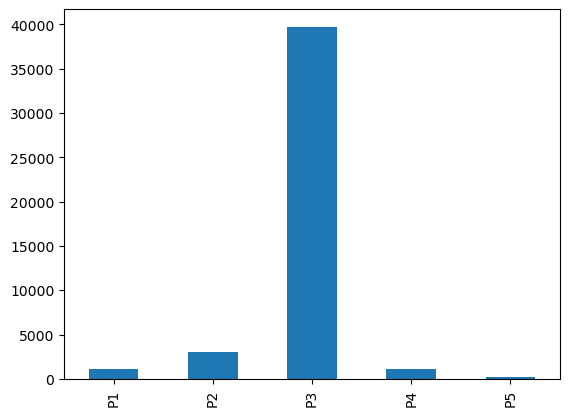

In [152]:
df['Priority'].value_counts().sort_index().plot(kind='bar')

    Distribution of the part of the component where the bugs occured

<AxesSubplot:>

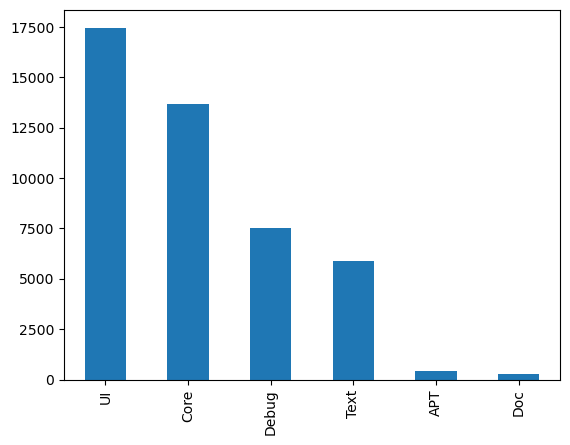

In [153]:
df['Component'].value_counts().sort_values(ascending=False).plot(kind='bar')

# Data Preparation    

    Step 1: Data Cleaning    

In [154]:
# cleaning the data first
# only taking the data that we need

df = df[['Title', 'Description', 'Priority']]
df = df.dropna()  # needed to drop na for the ML model
df['text'] = df['Title'] + ' ' + df['Description']
df = df.drop(columns=['Title', 'Description'])

df.head(5)

,Priority,text
0,P1,Icons needed for actions (1GI5UXW) JGS (8/8/01...
1,P3,README: Hit count not reset (1GET20Y) JGS (6/4...
2,P3,Use styled text in console (1G9S1YF) DW (2/26/...
3,P3,StringBuffer representation (1GE3BFA) JGS (5/2...
4,P2,Feature: use #toString to display variable val...


In [155]:
from fun_nlp_spacy_text import clean  # taking a function from self-made script

df['text'] = df['text'].apply(clean)
df = df[df['text'].str.len() > 50]  # filtering only with text that is valid, has more than 50 characters
df.sample(5)

,Priority,text
6907,P1,Default source lookup computed incorrectly Whe...
15333,P3,Java Model Exception appears mysteriously in ....
11050,P1,Moving linked resource onto self deletes linke...
23954,P3,CommentRecorderScanner.recordComment crashes o...
17817,P3,AppletMainTab has too many composites The Appl...


    Step 2: Train-Test Split    

In [156]:
# train test split first
# don't forget to set the random_state parameter
# use the text as the feature to predict level of the priority

x_train, x_test, y_train, y_test = train_test_split(df['text'],
                                                    df['Priority'],
                                                    test_size=0.2,  # test data 20% of the data
                                                    random_state=42,
                                                    stratify=df['Priority'])  # to retain dataset, to pertain the reproducibility

print('len of training data:', len(x_train))
print('len of test data:', len(x_test))

len of training data: 36040
len of test data: 9011


    Checking whether we already have the data we want

In [157]:
x_train.sample(3)

24511    Quick fix generate strange formatted code M5a;...
8103     App started with Run... does not get the curre...
17995    NPE when using ICU.reconcile(GET_AST_TRUE; ......
Name: text, dtype: object

In [158]:
x_test.sample(3)

44904    EncodingTests.testBug361356b failed on JRE 7 N...
43547    improve description for adding library with de...
7360     TVT2: mnemonic not workin in java template pre...
Name: text, dtype: object

In [159]:
y_train.sample(3)

22965    P3
26545    P3
20390    P3
Name: Priority, dtype: object

In [160]:
y_test.sample(3)

33589    P3
40670    P3
36532    P3
Name: Priority, dtype: object

# Machine Learning Models

## Model 1 : Linear SVC

    Step 1: Vectorizing the text first    

In [161]:
tfidf = TfidfVectorizer(min_df=10,
                        ngram_range=(1,2),
                        stop_words='english')
x_train_tf = tfidf.fit_transform(x_train)

x_train_tf

<36040x37998 sparse matrix of type '<class 'numpy.float64'>'
	with 2921470 stored elements in Compressed Sparse Row format>

    Step 2: Training the model using Classification Model: Linear Support Vector (SVC)

An algorithm that attempts to find a hyperplane to maximize the distance between classified samples.


In [162]:
%%time

from sklearn.svm import LinearSVC

model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(x_train_tf, y_train)

CPU times: user 2.46 s, sys: 70.9 ms, total: 2.53 s
Wall time: 3.18 s


LinearSVC(random_state=0, tol=1e-05)

    Step 3: Model Evaluation

Using several measurements, including: **Accuracy, Precision and Recall, and Class Imbalance**. Most of the functions already included in sklear.metrics method.

In [163]:
# vectorize the x_test first, then predict y_test from the vectorized x_test
# not using FIT_TRANSFORM(), but instead using TRANSFORM() ONLY!
# because we already fit the model before

x_test_tf = tfidf.transform(x_test)  
y_pred = model1.predict(x_test_tf)

#### Accuracy

In [164]:
# print the accuracy score
print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred))

Accuracy Score: 0.8761513705471091


#### Precision, Recall, and Confusion Matrix

In [165]:
metrics.confusion_matrix(y_test, y_pred)

array([[  19,    1,  199,    4,    0],
       [   6,   18,  576,    8,    0],
       [   8,   48, 7827,   19,    0],
       [   0,    5,  192,   31,    0],
       [   0,    0,   50,    0,    0]])

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


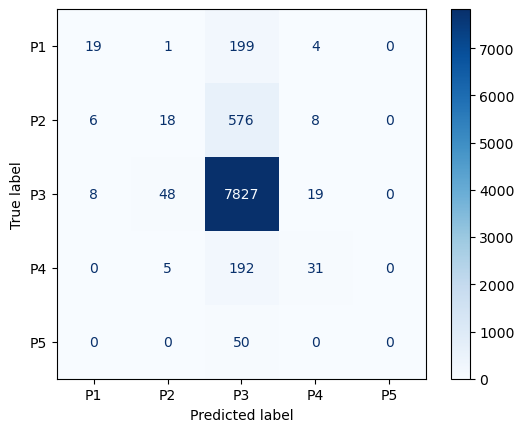

In [166]:
# plot the confusion matrix

metrics.plot_confusion_matrix(model1, x_test_tf, y_test, 
                              values_format='d', 
                              cmap=plt.cm.Blues)
plt.show()

In [167]:
# classification report
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          P1       0.58      0.09      0.15       223
          P2       0.25      0.03      0.05       608
          P3       0.89      0.99      0.93      7902
          P4       0.50      0.14      0.21       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.88      9011
   macro avg       0.44      0.25      0.27      9011
weighted avg       0.82      0.88      0.83      9011



/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

#### Important! Comparing to a Simple Baseline Approach    

This is to understand **whether our machine learning model gives additional value**. DummyClassifier makes predictions that ignore the input features.

In [168]:
# Using Dummy Classifier
# predict all as the one with the most frequent (y that frequently appears)

from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy='most_frequent')
clf.fit(x_train_tf, y_train)
y_pred_clf = clf.predict(x_test_tf)

print('Accuracy score using CLF:', metrics.accuracy_score(y_test, y_pred_clf))

Accuracy score using CLF: 0.8769281988680502


## Model 2: Dealing with Class Imbalance

In [169]:
# class imbalance using downsampling method
# for upsampling method using SMOTE (generating new observation), see PAGE 169

df['Priority'].value_counts()

P3    39506
P2     3038
P4     1138
P1     1117
P5      252
Name: Priority, dtype: int64

In [170]:
# downsampling method
# downside: loss of information

df_sample_p3 = df[df['Priority'] == 'P3'].sample(4000)  # just balance by yourself using intuition
df_sample_rest = df[df['Priority'] != 'P3']

df_downsample = pd.concat([df_sample_p3, df_sample_rest])
df_downsample['Priority'].value_counts()

P3    4000
P2    3038
P4    1138
P1    1117
P5     252
Name: Priority, dtype: int64

    All-in-All in One Chunk Code

In [171]:
df = df_downsample[['text', 'Priority']]
df = df.dropna()

    # Step 1: Data Preparation 

df['text'] = df['text'].apply(clean)

    # Step 2: Train-test Split Data

x_train, x_test, y_train, y_test = train_test_split(df['text'],
                                                    df['Priority'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['Priority'])

print('Training data len:', x_train.shape[0])
print('Test data len:', x_test.shape[0])

    # Step 3: Training ML Model

tfidf = TfidfVectorizer(min_df=10, ngram_range=(1,2), stop_words='english')
x_train_tf = tfidf.fit_transform(x_train)

model_1_svc = LinearSVC(random_state=0, tol=1e-5)
model_1_svc.fit(x_train_tf, y_train)

    # Step 4: Model Evaluation

x_test_tf = tfidf.transform(x_test)
y_pred = model_1_svc.predict(x_test_tf)

print('Accuracy score:', metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

Training data len: 7636
Test data len: 1909
Accuracy score: 0.5018334206390781
              precision    recall  f1-score   support

          P1       0.48      0.31      0.38       223
          P2       0.43      0.46      0.44       608
          P3       0.56      0.67      0.61       800
          P4       0.48      0.33      0.39       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.50      1909
   macro avg       0.39      0.35      0.36      1909
weighted avg       0.49      0.50      0.49      1909



In [172]:
# important! benchmarking to a business approach

clf = DummyClassifier(strategy='most_frequent')
clf.fit(x_train_tf, y_train)
y_pred_clf = clf.predict(x_test_tf)

print('Accuracy score using CLF:', metrics.accuracy_score(y_test, y_pred_clf))

Accuracy score using CLF: 0.41906757464641176


## Model 3: Cross-Validation

Model to train on different splots of data and validate also on different splits of data in a repetitive manner. Use cross-validation to detect overfitting, ie, failing to generalize a pattern.

In [178]:
# Vectorizing the data

tfidf = TfidfVectorizer(min_df=10, ngram_range=(1,2), stop_words='english')
df_tf = tfidf.fit_transform(df['text'])

# calculating cross validation score

from sklearn.model_selection import cross_val_score

score = cross_val_score(estimator=model_1_svc,
                        X=df_tf,
                        y=df['Priority'],
                        cv=5)

In [180]:
print('validation score of each iteration:', score)
print('mean value:', score.mean())
print('standard deviation value:', score.std())

validation score of each iteration: [0.45940283 0.43425877 0.44316396 0.42011524 0.36720796]
mean value: 0.4248297537977999
standard deviation value: 0.031505061570140935


## Model 4: GridSearch - Performing Hyperparameter Tuning (HPT)

Improve the accuracy of the model by evaluating different parameters used for the model.

    Step 1: Define training_pipline, steps that we would like to run.

The steps should be from sklearn library as well.    

In [187]:
from sklearn.pipeline import Pipeline

training_pipeline = Pipeline(
    steps=[('tfidf', TfidfVectorizer(stop_words='english')),
            ('model_2_svc', LinearSVC(random_state=42, tol=1e-5))]
)

    Step 2: Define the grid parameter, all the parameters that we want to look at

In [190]:
# there's a pattern for this which is -> [function]__[parameter]
# look at the book page 176
# or the official documentation at: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html

param_grid = [{
    'tfidf__min_df': [5,10],
    'tfidf__ngram_range': [(1,3), (1,6)],
    'model_2_svc__penalty': ['l2'],
    'model_2_svc__penalty': ['hinge'],
    'model_2_svc__max_iter': [10000]
},{
    'tfidf__min_df': [5, 10],
    'tfidf__ngram_range': [(1, 3), (1,6)],
    'model_2_svc__C': [1, 10],
    'model_2_svc__tol': [1e-2, 1e-3]
}]

    Build the GridSearchCV function and pass all the parameters we have 

In [191]:
# pass all the parameters to GridSearchCV function
# and fit it to the data we have

gridSearchProcessor = GridSearchCV(estimator=training_pipeline,
                                   param_grid=param_grid,
                                   cv=5)                        # we can pass the parameter for cross validation as well
gridSearchProcessor.fit(df['text'], df['Priority'])             # do not have to pass the vectorized data since it's already defined as training pipeline parameter

/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/taufiqurrohman/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_classes.py

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('model_2_svc',
                                        LinearSVC(random_state=42,
                                                  tol=1e-05))]),
             param_grid=[{'model_2_svc__max_iter': [10000],
                          'model_2_svc__penalty': ['hinge'],
                          'tfidf__min_df': [5, 10],
                          'tfidf__ngram_range': [(1, 3), (1, 6)]},
                         {'model_2_svc__C': [1, 10],
                          'model_2_svc__tol': [0.01, 0.001],
                          'tfidf__min_df': [5, 10],
                          'tfidf__ngram_range': [(1, 3), (1, 6)]}])

    Print the result!

In [192]:
best_params = gridSearchProcessor.best_params_
print('Best parameter based on the grid search method:', best_params)

best_score = gridSearchProcessor.best_score_
print('Best accuracy score based on the grid search method:', best_score)

Best parameter based on the grid search method: {'model_2_svc__C': 1, 'model_2_svc__tol': 0.001, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 3)}
Best accuracy score based on the grid search method: 0.43174436877946565


In [197]:
# in a from of dataframe

df_gridsearch_result = pd.DataFrame(gridSearchProcessor.cv_results_)        # pass it to dataframe
df_gridsearch_result[['rank_test_score', 'mean_test_score', 'params']       # make it tidier
                     ].sort_values(by='rank_test_score').head(10)                                                        

,rank_test_score,mean_test_score,params
8,1,0.431744,"{'model_2_svc__C': 1, 'model_2_svc__tol': 0.00..."
4,2,0.431640,"{'model_2_svc__C': 1, 'model_2_svc__tol': 0.01..."
9,3,0.427763,"{'model_2_svc__C': 1, 'model_2_svc__tol': 0.00..."
6,4,0.427554,"{'model_2_svc__C': 1, 'model_2_svc__tol': 0.01..."
5,5,0.427449,"{'model_2_svc__C': 1, 'model_2_svc__tol': 0.01..."
10,6,0.427344,"{'model_2_svc__C': 1, 'model_2_svc__tol': 0.00..."
7,7,0.424620,"{'model_2_svc__C': 1, 'model_2_svc__tol': 0.01..."
11,7,0.424620,"{'model_2_svc__C': 1, 'model_2_svc__tol': 0.00..."
12,9,0.397590,"{'model_2_svc__C': 10, 'model_2_svc__tol': 0.0..."
16,10,0.397486,"{'model_2_svc__C': 10, 'model_2_svc__tol': 0.0..."
